<h3 style="text-align: center;">
Emory University - Department of Economics
</h3>

<h4 style="text-align: center;">
Prof. Maria Arbatskaya, Ph.D.
</h4>

<h5 style="text-align: center;">
Student: Fareed Wajid Khan 

Date: December 11th, 2023
</h5>

### Table of contents

0. Packages and some specific settings
1. Access Keepa API
2. Amazon categories
3. Product history query
4. Variation query
5. Top sellers query

### 0. Packages and some specific settings

In [ ]:
pip install aiohttp

In [ ]:
pip install tqdm

In [ ]:
pip install keepa

In [ ]:
pip install asyncio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aiohttp
import tqdm
import keepa
import os
import asyncio

#plt.style.use('whitegrid') # Matplotlib style
plt.rcParams['figure.figsize'] = [6, 3] # Matplotlib figure size

# Set working directory (change to your own)
path = "/Users/fareedkhan/Documents/Thesis"
os.chdir(path)

# Data Organization & Preprocessing

In [2]:
import pandas as pd

# Import Data
original_data = pd.read_csv("Keepa BestSellers Jan 18 Unedited.csv")
modified_data = original_data.drop(['Locale', 'Image'], axis =1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Parsing Sales rank
def parse_sales_rank(row):
    if isinstance(row, str):
        parts = row.split('|')
        absolute_rank = parts[0].strip()
        top_1_percent = parts[1].strip()

        category_part = parts[-1].strip()
        category = category_part.split(';')[0].strip()

        return pd.Series([absolute_rank, top_1_percent, category])
    else:
        return pd.Series([None,None,None])

#S Split Subcategory sales rank for processing
new_columns = original_data['Sales Rank: Subcategory Sales Ranks'].apply(parse_sales_rank)
new_columns.columns = ['Absolute Rank', 'Top 1 Percent', 'Category']
modified_data = pd.concat([modified_data, new_columns], axis=1)


# Rempve unnessesary data
modified_data = modified_data.drop(['Sales Rank: Subcategory Sales Ranks'], axis =1)
modified_data = modified_data.drop(['Sales Rank: Reference'], axis =1)
modified_data = modified_data.drop(['Top 1 Percent'], axis =1)

# Convert Absolute Rank into numeric
modified_data['Absolute Rank'] = modified_data['Absolute Rank'].str.strip('# ')
modified_data['Absolute Rank'] = pd.to_numeric(modified_data['Absolute Rank'],errors='coerce')

#Count Variation ASIN
modified_data['Variation ASINs'] = modified_data['Variation ASINs'].fillna("")
modified_data['Variation ASIN Count'] = modified_data['Variation ASINs'].apply(lambda x: len(x.split(',')))


#modified_data.head()
#modified_data.to_csv('Modified.csv')


## Data Prep (Converting Data & One-Hot Encoding)

In [11]:
import statsmodels

# Categorizing Data
categorical_column_data = ['Buy Box Seller', 'Buy Box Used Seller', 'Buy Box Used: Condition', 'Categories: Root', 'Categories: Sub', 'Categories: Tree', 'ASIN', 'Product Codes: EAN', 'Product Codes: UPC', 'Product Codes: PartNumber', 'Parent ASIN', 'Variation ASINs', 'Freq. Bought Together', 'Type', 'Manufacturer', 'Brand', 'Product Group', 'Model', 'Variation Attributes', 'Color', 'Size', 'Edition', 'Format', 'Author', 'Contributors', 'Binding', 'Languages', 'Hazardous Materials', 'Category']
numeric_column_data = ['Sales Rank: Current', 'Amazon: 90 days OOS', 'New: 90 days OOS', 'Used: 90 days OOS', 'Sales Rank: 90 days avg.', 'Sales Rank: Drops last 90 days', 'Bought in past month','Reviews: Review Count', 'Buy Box 🚚: Current', 'Buy Box 🚚: 90 days avg.', 'Buy Box 🚚: Stock', 'Amazon: Current', 'Amazon: 90 days avg.', 'New: Current', 'New: 90 days avg.','New, 3rd Party FBA: Current','New: 90 days avg.','New, 3rd Party FBA: 90 days avg.', 'FBA Pick&Pack Fee', 'Referral Fee based on current Buy Box price', 'New, 3rd Party FBA: Current', 'New, 3rd Party FBA: 90 days avg.', 'New, Prime exclusive: Current', 'New, Prime exclusive: 90 days avg.', 'Lightning Deals: Current', 'Buy Box Used 🚚: Current', 'Buy Box Used 🚚: 90 days avg.', 'Used: Current', 'Used: 90 days avg.', 'Used, like new 🚚: Current', 'Used, like new 🚚: 90 days avg.', 'Used, very good 🚚: Current', 'Used, very good 🚚: 90 days avg.', 'Used, good 🚚: Current', 'Used, good 🚚: 90 days avg.', 'Used, acceptable 🚚: Current', 'Used, acceptable 🚚: 90 days avg.', 'Warehouse Deals: Current', 'Warehouse Deals: 90 days avg.', 'List Price: Current', 'List Price: 90 days avg.', 'Rental: Current', 'Rental: 90 days avg.', 'eBay New 🚚: Current', 'eBay New 🚚: 90 days avg.', 'eBay Used 🚚: Current', 'eBay Used 🚚: 90 days avg.', 'New Offer Count: Current', 'New Offer Count: 90 days avg.', 'Count of retrieved live offers: New, FBM', 'Used Offer Count: Current', 'Used Offer Count: 90 days avg.', 'Number of Items', 'Number of Pages', 'Package: Dimension (cm³)', 'Package: Weight (g)', 'Package: Quantity', 'Item: Dimension (cm³)', 'Item: Weight (g)', 'One Time Coupon: Absolute', 'One Time Coupon: Percentage', 'Absolute Rank', 'Variation ASIN Count']
binary_column_data = ['Buy Box: Is FBA', 'Buy Box: Unqualified', 'Lightning Deals: Upcoming Deal', 'Buy Box Used: Is FBA', 'Categories: Launchpad', 'Adult Product', 'Trade-In Eligible', 'Prime Eligible (Buy Box)', 'Subscribe and Save']

# Fill NA categorical data
for column in categorical_column_data:
    modified_data[column] = modified_data[column].fillna('Missing') 

# Encode categorical data (one hot encoding // high dimensionality)
df_categorical_encoded = pd.get_dummies(modified_data, columns=categorical_column_data, dtype=int)

#Convert from float to numeric for numeric data
for column in numeric_column_data:
    df_categorical_encoded[column] = pd.to_numeric(df_categorical_encoded[column], errors='coerce') 
    df_categorical_encoded[column].fillna(0)

#Encoding binary data in column to 1/0
for column in binary_column_data:
    df_categorical_encoded[column] = df_categorical_encoded[column].map(lambda x: 1 if x == 'yes' else 0)

#Encode Rating data
df_categorical_encoded['Reviews: Rating'] = pd.to_numeric(df_categorical_encoded['Reviews: Rating'], errors='coerce')

# Convert % data into numeric
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'].str.replace('%', '').astype(float)
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'].fillna(0)
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'] /100

# Convert % data into numeric
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = df_categorical_encoded['Subscribe and Save Coupon: Percentage'].str.replace('%', '', regex=False)
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = pd.to_numeric(df_categorical_encoded['Subscribe and Save Coupon: Percentage'], errors='coerce')
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = df_categorical_encoded['Subscribe and Save Coupon: Percentage']/100
df_categorical_encoded['Subscribe and Save Coupon: Percentage']= df_categorical_encoded['Subscribe and Save Coupon: Percentage'].fillna(0)

# Convert % data into numeric
df_categorical_encoded['Buy Box 🚚: 90 days OOS'] = df_categorical_encoded['Buy Box 🚚: 90 days OOS'].str.replace('%', '', regex=False)
df_categorical_encoded['Buy Box 🚚: 90 days OOS'] = pd.to_numeric(df_categorical_encoded['Buy Box 🚚: 90 days OOS'], errors='coerce')
df_categorical_encoded['Buy Box 🚚: 90 days OOS']= df_categorical_encoded['Buy Box 🚚: 90 days OOS'].fillna(0)

# Encode Time Data
time_column_data = ['Last Price Change', 'Tracking since', 'Listed since', 'Publication Date', 'Release Date']
for column in time_column_data:
    df_categorical_encoded = df_categorical_encoded.drop(column, axis=1)

 
# Remove '$' signs from data
for column in df_categorical_encoded.columns:
    if df_categorical_encoded[column].dtype == object:
        if df_categorical_encoded[column].str.contains('\$', na=False).any():
            print(f"Column '{column}' contains a '$'")
            df_categorical_encoded[column] = df_categorical_encoded[column].str.replace('\$', '', regex=True)



final_data = df_categorical_encoded

Column 'New, 3rd Party FBM 🚚: Current' contains a '$'
Column 'New, 3rd Party FBM 🚚: 90 days avg.' contains a '$'


### Fill NA Values w/ Mean averages

In [12]:
#Check for Final null data
for column in final_data:
    if final_data[column].isnull().any():
        print(column)


Sales Rank: 90 days avg.
Sales Rank: Drops last 90 days
Bought in past month
Reviews: Rating
Reviews: Review Count
Ratings - Format Specific
Review Count - Format Specific
Buy Box 🚚: Current
Buy Box 🚚: 90 days avg.
Buy Box 🚚: Stock
Amazon: Current
Amazon: 90 days avg.
Amazon: 90 days OOS
New: Current
New: 90 days avg.
New: 90 days OOS
New, 3rd Party FBA: Current
New, 3rd Party FBA: 90 days avg.
FBA Pick&Pack Fee
Referral Fee based on current Buy Box price
New, 3rd Party FBM 🚚: Current
New, 3rd Party FBM 🚚: 90 days avg.
New, Prime exclusive: Current
New, Prime exclusive: 90 days avg.
Lightning Deals: Current
Buy Box Used 🚚: Current
Buy Box Used 🚚: 90 days avg.
Used: Current
Used: 90 days avg.
Used: 90 days OOS
Used, like new 🚚: Current
Used, like new 🚚: 90 days avg.
Used, very good 🚚: Current
Used, very good 🚚: 90 days avg.
Used, good 🚚: Current
Used, good 🚚: 90 days avg.
Used, acceptable 🚚: Current
Used, acceptable 🚚: 90 days avg.
Warehouse Deals: Current
Warehouse Deals: 90 days avg.


In [15]:
columns_to_fill = [
    'Sales Rank: 90 days avg.', 'Sales Rank: Drops last 90 days', 'Bought in past month',
    'Reviews: Rating', 'Reviews: Review Count', 'Ratings - Format Specific',
    'Review Count - Format Specific', 'Buy Box 🚚: Current', 'Buy Box 🚚: 90 days avg.', 'Buy Box 🚚: Stock', 
    'Amazon: Current', 'Amazon: 90 days avg.', 'Amazon: 90 days OOS',
    'New: Current', 'New: 90 days avg.', 'New: 90 days OOS', 'New, 3rd Party FBA: Current',
    'New, 3rd Party FBA: 90 days avg.', 'FBA Pick&Pack Fee', 'Referral Fee based on current Buy Box price',
    'New, 3rd Party FBM 🚚: Current', 'New, 3rd Party FBM 🚚: 90 days avg.', 'New, Prime exclusive: Current',
    'New, Prime exclusive: 90 days avg.', 'Lightning Deals: Current', 'Buy Box Used 🚚: Current', 'Buy Box Used 🚚: 90 days avg.', 'Used: Current', 'Used: 90 days avg.', 'Used: 90 days OOS',
    'Used, like new 🚚: Current', 'Used, like new 🚚: 90 days avg.', 'Used, very good 🚚: Current',
    'Used, very good 🚚: 90 days avg.', 'Used, good 🚚: Current', 'Used, good 🚚: 90 days avg.',
    'Used, acceptable 🚚: Current', 'Used, acceptable 🚚: 90 days avg.', 'Warehouse Deals: Current',
    'Warehouse Deals: 90 days avg.', 'List Price: Current', 'List Price: 90 days avg.',
    'Rental: Current', 'Rental: 90 days avg.', 'eBay New 🚚: Current', 'eBay New 🚚: 90 days avg.',
    'eBay Used 🚚: Current', 'eBay Used 🚚: 90 days avg.', 'New Offer Count: Current',
    'Count of retrieved live offers: New, FBA', 'Count of retrieved live offers: New, FBM',
    'Used Offer Count: Current', 'Used Offer Count: 90 days avg.', 'Number of Items',
    'Number of Pages', 'Package: Dimension (cm³)', 'Package: Weight (g)', 'Package: Quantity',
    'Item: Dimension (cm³)', 'Item: Weight (g)', 'One Time Coupon: Absolute',
    'One Time Coupon: Percentage', 'Absolute Rank'
]

# for column in columns_to_fill:
#     if column in final_data.columns:
#         if final_data[column].dtype == object:
#             print(column)
for column in columns_to_fill:
    if column in final_data.columns:
        final_data[column] = pd.to_numeric(final_data[column], errors='coerce')
        column_mean = final_data[column].mean()
        final_data[column] = final_data[column].fillna(0)
    else:
        print(f"{column} not found in DataFrame.")

## Splitting and Training

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


modified_data_testing = final_data.drop(['Title'], axis = 1)
# Dropping title

# Splitting Data
X = modified_data_testing.drop('Sales Rank: Current', axis=1)  # Features
y = modified_data_testing['Sales Rank: Current']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# MSE Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Mean Squared Error: 61304.49261563608


## Scatter Plot - OLS

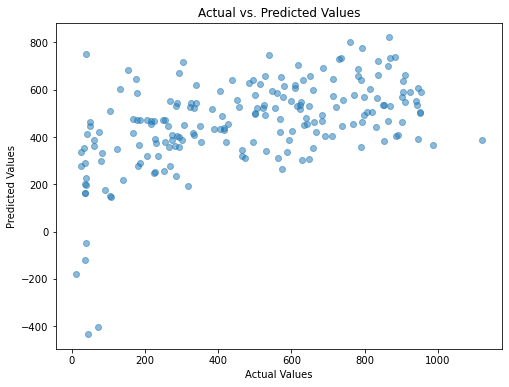

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


## Residual Plot - OLS

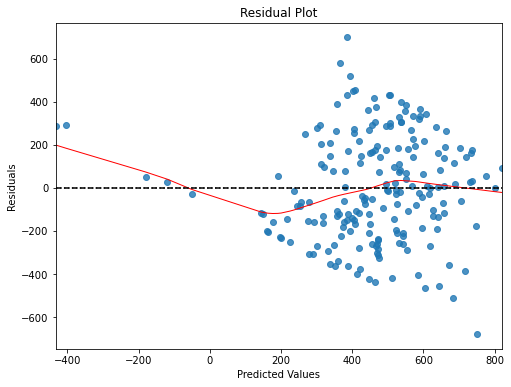

In [18]:
residuals = y_test - predictions

plt.figure(figsize=(8, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


## Coefficient Plot - OLS

do not run this

In [19]:
feature_names = X_train.columns
coefficients = model.coef_

# Create a DataFrame for easier plotting
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Sort the DataFrame by the absolute value of the coefficients
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


KeyboardInterrupt: 

# Lasso

In [20]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01)  

lasso_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 886114.7419575324, tolerance: 6577.5182755
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

Lasso Predictions

In [21]:
# Making predictions
predictions_lasso = lasso_model.predict(X_test)

# Calculating the Mean Squared Error (MSE)
mse_lasso = mean_squared_error(y_test, predictions_lasso)
print(f"Mean Squared Error for Lasso Regression: {mse_lasso}")


Mean Squared Error for Lasso Regression: 82534.60276674698


Cross Validation for Lasso Alpha value

In [22]:
from sklearn.linear_model import LassoCV

# Initialize and fit the LassoCV to find the best alpha
lasso_cv_model = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv_model.fit(X_train, y_train)

# Best alpha
print("Best alpha using LassoCV: ", lasso_cv_model.alpha_)

# You can now initialize a new Lasso model with this best alpha
lasso_model_optimal = Lasso(alpha=lasso_cv_model.alpha_)
lasso_model_optimal.fit(X_train, y_train)


Best alpha using LassoCV:  13545.149148283259


Lasso(alpha=13545.149148283259)

Lasso w/ Best Alpha

In [23]:
lasso_model_best = Lasso(alpha=13545.149148283259)  

lasso_model_best.fit(X_train, y_train)

predictions_lasso_best = lasso_model_best.predict(X_test)

# Calculating the Mean Squared Error (MSE)
mse_lasso_best = mean_squared_error(y_test, predictions_lasso_best)
print(f"Mean Squared Error for Lasso Regression: {mse_lasso_best}")


Mean Squared Error for Lasso Regression: 68272.25781083392


In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming final_data is your DataFrame and already includes all necessary columns

# Dropping unnecessary column
modified_data_testing = final_data.drop(['Title'], axis=1)

# Selecting only specific features
X = modified_data_testing[['Reviews: Rating', 'Reviews: Review Count', 'Buy Box: Is FBA', 
                           'FBA Pick&Pack Fee', 'New Offer Count: Current', 'Variation ASIN Count']]  # Features

# Applying logarithmic transformation to the target variable
y = np.log(modified_data_testing['Sales Rank: Current'])  # Target variable, log-transformed

# Splitting Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train2, y_train2)
predictions2 = model.predict(X_test2)

# MSE Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.8081760514277218


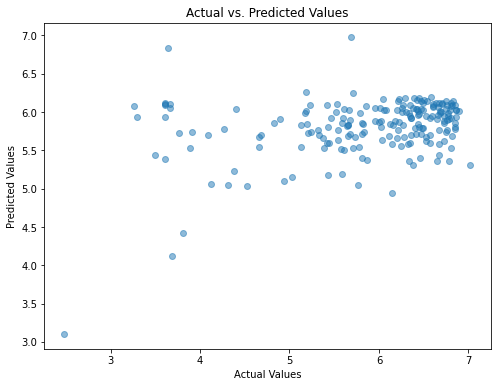

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.scatter(y_test2, predictions2, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

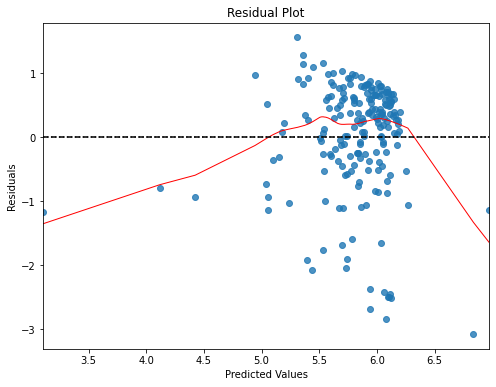

In [31]:
residuals2 = y_test2 - predictions2

plt.figure(figsize=(8, 6))
sns.residplot(x=predictions2, y=residuals2, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()